In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('GPU detected:', tf.config.list_physical_devices('GPU'))

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### NER Dataset

Dataset from Kaggle


In [0]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method = 'ffill')

In [3]:
data.head(24)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Soo what we see is a sentence of 24 words with every words POS tagged and marked as the Name Entity (and which type exactly) or not. 

The dataset has 47959 sentences. 

*Info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
print('Unique words in out corpus:', data['Word'].nunique())
print('Unique tags in out corpus:', data['Tag'].nunique())

Unique words in out corpus: 23008
Unique tags in out corpus: 17


In [0]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [0]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [7]:
num_words, num_tags

(23009, 17)

### Sentences and Corresponsing Tags

In [0]:
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    agg_func = lambda s: [(w, p, t) for w,p,t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
    self.grouped = self.data.groupby('Sentence #').apply(agg_func)
    self.sentences = [s for s in self.grouped]

In [0]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

So we splitted the data into separate objects (1 sentence = 1 object).

In [0]:
words2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

### Bidirectional LSTM Model

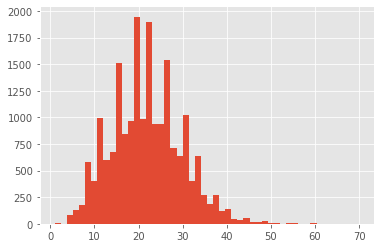

In [12]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[words2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

In [0]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

**SpatialDropout1D**

Example is this: shape(x) = [k, l, m, n] and noise_shape = [k, 1, 1, n]. In this case, each batch and channel component will be kept independently, but each row and column will be kept or not kept together. In other words, the whole [l, m] feature map will be either kept or dropped.

You may want to do this to account for adjacent pixels correlation, especially in the early convolutional layers. Effectively, you want to prevent co-adaptation of pixels with its neighbors across the feature maps, and make them learn as if no other feature maps exist. This is exactly what SpatialDropout2D is doing: it promotes independence between feature maps.

The SpatialDropout1D is very similar: given shape(x) = [k, l, m] it uses noise_shape = [k, 1, m] and drops entire 1-D feature maps.
___
**Bidirectional LSTMs**

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.
___
**TimeDistributedDense**

TimeDistributedDense applies a same Dense (fully-connected) operation to every timestep of a 3D tensor. This wrapper allows us to apply a layer to every temporal slice of an input.

In [39]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1150450   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,274,667
Trainable params: 1,274,667
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [41]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, mode = 'max')
callbacks = [ early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 10,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/50
224/224 [==============================] - 98s 439ms/step - loss: 0.4237 - accuracy: 0.9300 - val_loss: 0.2072 - val_accuracy: 0.9398
Epoch 2/50
224/224 [==============================] - 98s 439ms/step - loss: 0.1623 - accuracy: 0.9497 - val_loss: 0.1428 - val_accuracy: 0.9550
Epoch 3/50
224/224 [==============================] - 98s 439ms/step - loss: 0.1072 - accuracy: 0.9690 - val_loss: 0.0952 - val_accuracy: 0.9750
Epoch 4/50
224/224 [==============================] - 98s 436ms/step - loss: 0.0677 - accuracy: 0.9813 - val_loss: 0.0745 - val_accuracy: 0.9794
Epoch 5/50
224/224 [==============================] - 97s 433ms/step - loss: 0.0502 - accuracy: 0.9858 - val_loss: 0.0678 - val_accuracy: 0.9808
Epoch 6/50
224/224 [==============================] - 97s 435ms/step - loss: 0.0408 - accuracy: 0.9883 - val_loss: 0.0656 - val_accuracy: 0.9817
Epoch 7/50
224/224 [==============================] - 99s 441ms/step - loss: 0.0350 - accuracy: 0.9896 - val_loss: 0.0662 - val_ac

### Evaluation


In [42]:
model.evaluate(X_test, np.array(y_test))

62/62 [==============================] - 2s 37ms/step - loss: 0.0756 - accuracy: 0.9808


[0.0756278857588768, 0.9808366894721985]

In [36]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print("{:15} {} \t{} ".format('Words', 'Tags', 'Pred'))
print('-'*30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
  print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

Words           Tags 	Pred 
------------------------------
The            O	O
agreement      O	O
comes          O	O
one            O	O
week           O	O
after          O	O
Japan          B-geo	B-geo
adopted        O	O
new            O	O
defense        O	O
policy         O	O
guidelines     O	O
that           O	O
would          O	O
allow          O	O
the            O	O
joint          O	O
development    O	O
of             O	O
a              O	O
missile        O	O
defense        O	O
system         O	O
with           O	O
the            O	O
United         B-geo	B-geo
States         I-geo	I-geo
.              O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despoiling     O	O
despo

Looks good. 

With test accuracy of 0.9808 for max(10) epoches this looks like a valid way for looking for name entities.